# Model Evaluation for Text Generation

Evaluating different parameter settings for chatMGL

## Initializations

In [2]:
import os
import sys

In [3]:
# Run this only for colab
from google.colab import drive

drive.mount("/content/drive")
ROOT_PATH = "/content/drive/MyDrive/epfl/modernNLP/generative_model/src/"
print(os.listdir(ROOT_PATH))

sys.path.append(ROOT_PATH)
os.chdir(ROOT_PATH)

Mounted at /content/drive
['RLHF_pipeline.ipynb', 'reward_model.py', 'gen_script_chatMGL.py', 'generative_model.py', 'evaluation_using_Reward_model.ipynb', 'utils', 'notebooks', 'dataset', '__pycache__', 'evaluation.ipynb']


In [4]:
#%pip install -U -r ../requirements.txt
%pip install trl
%pip install torchmetrics
%pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [5]:
import torch
import torch.utils.data

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_constant_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import random

import numpy as np
import pandas as pd

import json
import gc
import pprint

torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

SEED = 42

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Hardware: GPU (cuda)")
else:
    print("Hardware: CPU")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Working dir:",os.getcwd())

Hardware: GPU (cuda)
Working dir: /content/drive/MyDrive/epfl/modernNLP/generative_model/src


## Data Loading


In [6]:
from dataset.RLHF_dataset import RLHFDataset

TRAIN_DATA_PATH = "../dataset/RLHF/train.json"
TEST_DATA_PATH = "../dataset/Test/small_test.json"
VAL_DATA_PATH = "../dataset/RLHF/val.json"

MAX_SEQ_LEN = 1024
MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

train_dataset = RLHFDataset(TRAIN_DATA_PATH, tokenizer, MAX_SEQ_LEN)
test_dataset = RLHFDataset(TEST_DATA_PATH, tokenizer, MAX_SEQ_LEN)
val_dataset = RLHFDataset(VAL_DATA_PATH, tokenizer, MAX_SEQ_LEN)

test_data = json.load(open(TEST_DATA_PATH, "r"))

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 4241
Test samples: 60
Validation samples: 481


## Model Initializations

In [31]:
from generative_model import GenerativeModel
path = "/content/drive/MyDrive/epfl/modernNLP/generative_model/models/generative_model/gpt2_finetuned_large-1-epoch"
model = GenerativeModel(path, DEVICE)

## Model Evaluation (NLP Scoring)

In [33]:
def get_model_responses(
    model,
    max_new_tokens=150,
    do_sample=True,
    num_beams=2,
    length_penalty=0.0,
    early_stopping=True,
):
    labels = []
    responses = []
    for index, entry in tqdm(enumerate(test_dataset)):
        question = entry["question"]
        label = entry["answer"]
        question_ids = entry["question_input_ids"]

        response = model.generate(
            question,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            num_beams=num_beams,
            length_penalty=length_penalty
        )

        labels.append(label)
        responses.append(response)
        #print(index)

    return labels, responses

### Beam Size Testing

In [15]:
from utils.utils import get_bert_scores, get_rouge_scores, get_bleu_scores

beam_sizes = [1, 2, 4]

rouge_results = {"rouge1": [], "rouge2": [], "rougeL": [], "rougeLsum": []}
bert_results = {"bert_f1": [], "bert_recall": [], "bert_precision": []}
bleu_results = {"bleu": [], "bleu1": [], "bleu4": [], "brevity": []}

for index, beam_size in enumerate(beam_sizes):
    print(f"Beam size: {beam_size}")

    labels, responses = get_model_responses(model, num_beams=beam_size)

    # Calculate and save BERT scores
    # bert_f1, bert_recall, bert_precision, = get_bert_scores(responses, labels)
    # bert_results["bert_f1"].append(bert_f1)
    # bert_results["bert_recall"].append(bert_recall)
    # bert_results["bert_precision"].append(bert_precision)

    scale = 100.0

    # Calculate and save ROUGE scores
    rouge1, rouge2, rougeL, rougeLsum = get_rouge_scores(responses, labels)
    rouge_results["rouge1"].append(scale * rouge1)
    rouge_results["rouge2"].append(scale * rouge2)
    rouge_results["rougeL"].append(scale * rougeL)
    rouge_results["rougeLsum"].append(scale * rougeLsum)

    # Calculate and save BLEU scores
    bleu, bleu1, bleu4, brevity = get_bleu_scores(responses, labels)
    bleu_results["bleu"].append(scale * bleu)
    bleu_results["bleu1"].append(scale * bleu1)
    bleu_results["bleu4"].append(scale * bleu4)
    bleu_results["brevity"].append(scale * brevity)

    print(f"ROUGE results: {rouge_results}")
    #print(f"BERT results: {bert_results}")
    print(f"BLEU results: {bleu_results}")

Beam size: 1


60it [06:10,  6.18s/it]
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

ROUGE results: {'rouge1': [29.765583629906278], 'rouge2': [10.402560452761774], 'rougeL': [19.25494060558412], 'rougeLsum': [23.227916489390356]}
BLEU results: {'bleu': [3.4639221336229493], 'bleu1': [16.679487520930987], 'bleu4': [1.799115656580549], 'brevity': [81.94996099566835]}
Beam size: 2


60it [06:46,  6.77s/it]


ROUGE results: {'rouge1': [29.765583629906278, 26.05251873560615], 'rouge2': [10.402560452761774, 10.035223660028002], 'rougeL': [19.25494060558412, 18.856178412792847], 'rougeLsum': [23.227916489390356, 21.580747714250954]}
BLEU results: {'bleu': [3.4639221336229493, 2.9655214694210397], 'bleu1': [16.679487520930987, 13.532495704728548], 'bleu4': [1.799115656580549, 1.697805390030687], 'brevity': [81.94996099566835, 78.06848533543906]}
Beam size: 4


60it [06:48,  6.81s/it]


ROUGE results: {'rouge1': [29.765583629906278, 26.05251873560615, 25.270534297004854], 'rouge2': [10.402560452761774, 10.035223660028002, 9.728133015530203], 'rougeL': [19.25494060558412, 18.856178412792847, 18.423186624116767], 'rougeLsum': [23.227916489390356, 21.580747714250954, 20.968082554576718]}
BLEU results: {'bleu': [3.4639221336229493, 2.9655214694210397, 3.353485056780117], 'bleu1': [16.679487520930987, 13.532495704728548, 13.276261076507826], 'bleu4': [1.799115656580549, 1.697805390030687, 1.8911145147308455], 'brevity': [81.94996099566835, 78.06848533543906, 77.16679210166471]}


In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=fd3e6d00e7c5151e1e26dc3128b2e79d54cf3bc6214f9fe76cf3ac1bb1bfbd35
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


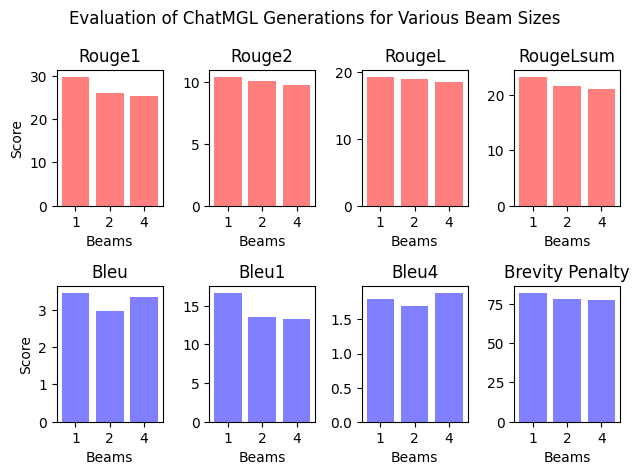

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)

color_palette = ["gray"]

beam_sizes = ["1", "2", "4"]
axs[0, 0].bar(beam_sizes, rouge_results["rouge1"], color=["red"], alpha=0.5)
axs[0, 0].set_title("Rouge1")
axs[0, 0].set_ylabel("Score")
axs[0, 0].set_xlabel("Beams")

axs[0, 1].bar(beam_sizes, rouge_results["rouge2"], color=["red"], alpha=0.5)
axs[0, 1].set_title("Rouge2")
#axs[0, 1].set_ylabel("Score")
axs[0, 1].set_xlabel("Beams")

axs[0, 2].bar(beam_sizes, rouge_results["rougeL"], color=["red"], alpha=0.5)
axs[0, 2].set_title("RougeL")
#axs[0, 2].set_ylabel("Score")
axs[0, 2].set_xlabel("Beams")

axs[0, 3].bar(beam_sizes, rouge_results["rougeLsum"], color=["red"], alpha=0.5)
axs[0, 3].set_title("RougeLsum")
#axs[0, 3].set_ylabel("Score")
axs[0, 3].set_xlabel("Beams")

axs[1, 0].bar(beam_sizes, bleu_results["bleu"], color=["blue"], alpha=0.5)
axs[1, 0].set_title("Bleu")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_xlabel("Beams")

axs[1, 1].bar(beam_sizes, bleu_results["bleu1"], color=["blue"], alpha=0.5)
axs[1, 1].set_title("Bleu1")
#axs[1, 1].set_ylabel("Score")
axs[1, 1].set_xlabel("Beams")

axs[1, 2].bar(beam_sizes, bleu_results["bleu4"], color=["blue"], alpha=0.5)
axs[1, 2].set_title("Bleu4")
#axs[1, 2].set_ylabel("Score")
axs[1, 2].set_xlabel("Beams")

axs[1, 3].bar(beam_sizes, bleu_results["brevity"], color=["blue"], alpha=0.5)
axs[1, 3].set_title("Brevity Penalty")
#axs[1, 3].set_ylabel("Score")
axs[1, 3].set_xlabel("Beams")

fig.suptitle("Evaluation of ChatMGL Generations for Various Beam Sizes")
fig.tight_layout()
fig.show()





In [35]:
from utils.utils import get_bert_scores, get_rouge_scores, get_bleu_scores

penalties = [-1.5, 0, 1.5]

rouge_results = {"rouge1": [], "rouge2": [], "rougeL": [], "rougeLsum": []}
bert_results = {"bert_f1": [], "bert_recall": [], "bert_precision": []}
bleu_results = {"bleu": [], "bleu1": [], "bleu4": [], "brevity": []}

for index, penalty in enumerate(penalties):
    print(f"Penalty {penalties}")

    labels, responses = get_model_responses(model, num_beams=1, length_penalty=penalty)

    # Calculate and save BERT scores
    # bert_f1, bert_recall, bert_precision, = get_bert_scores(responses, labels)
    # bert_results["bert_f1"].append(bert_f1)
    # bert_results["bert_recall"].append(bert_recall)
    # bert_results["bert_precision"].append(bert_precision)

    scale = 100.0

    # Calculate and save ROUGE scores
    rouge1, rouge2, rougeL, rougeLsum = get_rouge_scores(responses, labels)
    rouge_results["rouge1"].append(scale * rouge1)
    rouge_results["rouge2"].append(scale * rouge2)
    rouge_results["rougeL"].append(scale * rougeL)
    rouge_results["rougeLsum"].append(scale * rougeLsum)

    # Calculate and save BLEU scores
    bleu, bleu1, bleu4, brevity = get_bleu_scores(responses, labels)
    bleu_results["bleu"].append(scale * bleu)
    bleu_results["bleu1"].append(scale * bleu1)
    bleu_results["bleu4"].append(scale * bleu4)
    bleu_results["brevity"].append(scale * brevity)

    print(f"ROUGE results: {rouge_results}")
    #print(f"BERT results: {bert_results}")
    print(f"BLEU results: {bleu_results}")

Penalty [-1.5, 0, 1.5]


60it [06:12,  6.21s/it]


ROUGE results: {'rouge1': [29.745818037942563], 'rouge2': [10.680953523272137], 'rougeL': [19.163484239577286], 'rougeLsum': [23.965104787025137]}
BLEU results: {'bleu': [3.5778881405306566], 'bleu1': [16.614853649107726], 'bleu4': [1.8281656097592882], 'brevity': [84.71971171758244]}
Penalty [-1.5, 0, 1.5]


60it [06:11,  6.20s/it]


ROUGE results: {'rouge1': [29.745818037942563, 30.757174171349856], 'rouge2': [10.680953523272137, 11.087446560082304], 'rougeL': [19.163484239577286, 19.65270446803481], 'rougeLsum': [23.965104787025137, 24.20178382108434]}
BLEU results: {'bleu': [3.5778881405306566, 3.381415697744503], 'bleu1': [16.614853649107726, 17.729520996803007], 'bleu4': [1.8281656097592882, 1.7406162875304425], 'brevity': [84.71971171758244, 82.17031950824783]}
Penalty [-1.5, 0, 1.5]


60it [06:08,  6.15s/it]


ROUGE results: {'rouge1': [29.745818037942563, 30.757174171349856, 31.083053618525625], 'rouge2': [10.680953523272137, 11.087446560082304, 11.046325957687502], 'rougeL': [19.163484239577286, 19.65270446803481, 19.937274400082245], 'rougeLsum': [23.965104787025137, 24.20178382108434, 24.011898117219545]}
BLEU results: {'bleu': [3.5778881405306566, 3.381415697744503, 3.7010803518188777], 'bleu1': [16.614853649107726, 17.729520996803007, 17.297177944726684], 'bleu4': [1.8281656097592882, 1.7406162875304425, 1.924233708305703], 'brevity': [84.71971171758244, 82.17031950824783, 83.7081166849351]}


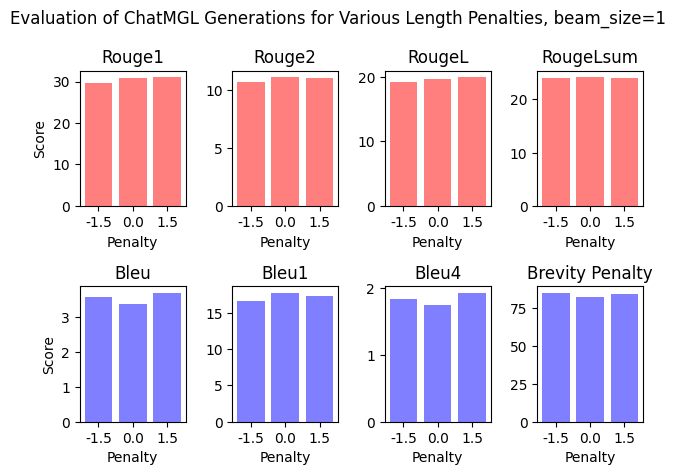

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)

color_palette = ["gray"]

penalties = ["-1.5", "0.0", "1.5"]
axs[0, 0].bar(penalties, rouge_results["rouge1"], color=["red"], alpha=0.5)
axs[0, 0].set_title("Rouge1")
axs[0, 0].set_ylabel("Score")
axs[0, 0].set_xlabel("Penalty")

axs[0, 1].bar(penalties, rouge_results["rouge2"], color=["red"], alpha=0.5)
axs[0, 1].set_title("Rouge2")
#axs[0, 1].set_ylabel("Score")
axs[0, 1].set_xlabel("Penalty")

axs[0, 2].bar(penalties, rouge_results["rougeL"], color=["red"], alpha=0.5)
axs[0, 2].set_title("RougeL")
#axs[0, 2].set_ylabel("Score")
axs[0, 2].set_xlabel("Penalty")

axs[0, 3].bar(penalties, rouge_results["rougeLsum"], color=["red"], alpha=0.5)
axs[0, 3].set_title("RougeLsum")
#axs[0, 3].set_ylabel("Score")
axs[0, 3].set_xlabel("Penalty")

axs[1, 0].bar(penalties, bleu_results["bleu"], color=["blue"], alpha=0.5)
axs[1, 0].set_title("Bleu")
axs[1, 0].set_ylabel("Score")
axs[1, 0].set_xlabel("Penalty")

axs[1, 1].bar(penalties, bleu_results["bleu1"], color=["blue"], alpha=0.5)
axs[1, 1].set_title("Bleu1")
#axs[1, 1].set_ylabel("Score")
axs[1, 1].set_xlabel("Penalty")

axs[1, 2].bar(penalties, bleu_results["bleu4"], color=["blue"], alpha=0.5)
axs[1, 2].set_title("Bleu4")
#axs[1, 2].set_ylabel("Score")
axs[1, 2].set_xlabel("Penalty")

axs[1, 3].bar(penalties, bleu_results["brevity"], color=["blue"], alpha=0.5)
axs[1, 3].set_title("Brevity Penalty")
#axs[1, 3].set_ylabel("Score")
axs[1, 3].set_xlabel("Penalty")

fig.suptitle("Evaluation of ChatMGL Generations for Various Length Penalties, beam_size=1")
fig.tight_layout()
fig.show()


In [38]:
from utils.utils import get_bert_scores, get_rouge_scores, get_bleu_scores

penalties = [-1.5, 0, 1.5]

bert_results = {"bert_f1": [], "bert_recall": [], "bert_precision": []}

labels, responses = get_model_responses(model, num_beams=1, length_penalty=1.5)



60it [06:07,  6.13s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 10>:10                                                                            │
│                                                                                                  │
│ /content/drive/MyDrive/epfl/modernNLP/generative_model/src/utils/utils.py:45 in get_bert_scores  │
│                                                                                                  │
│    42 │   Returns:                                                                               │
│    43 │   │   _type_: _description_                                                              │
│    44 │   """                                                                                    │
│ ❱  45 │   bertscore = load("bertscore")                                                          │
│    46 │   results = bertscore.compute(                                                           │
│    47 │   │   predictions=predictions, references=labels, model_type=model_type                  │
│    48 │   )                                                                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/evaluate/loading.py:731 in load                          │
│                                                                                                  │
│   728 │   │   `evaluate.EvaluationModule`                                                        │
│   729 │   """                                                                                    │
│   730 │   download_mode = DownloadMode(download_mode or DownloadMode.REUSE_DATASET_IF_EXISTS)    │
│ ❱ 731 │   evaluation_module = evaluation_module_factory(                                         │
│   732 │   │   path, module_type=module_type, revision=revision, download_config=download_confi   │
│   733 │   )                                                                                      │
│   734 │   evaluation_cls = import_main_class(evaluation_module.module_path)                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/evaluate/loading.py:680 in evaluation_module_factory     │
│                                                                                                  │
│   677 │   │   │   │   except Exception as e2:  # noqa: if it's not in the cache, then it doesn   │
│   678 │   │   │   │   │   pass                                                                   │
│   679 │   │   │   if not isinstance(e1, (ConnectionError, FileNotFoundError)):                   │
│ ❱ 680 │   │   │   │   raise e1 from None                                                         │
│   681 │   │   │   raise FileNotFoundError(                                                       │
│   682 │   │   │   │   f"Couldn't find a module script at {r

In [43]:
%pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.3 MB/s eta 0:00:00


In [44]:
# Calculate and save BERT scores
print(labels, responses)

bert_f1, bert_recall, bert_precision, = get_bert_scores(responses, labels)
bert_results["bert_f1"].append(bert_f1)
bert_results["bert_recall"].append(bert_recall)
bert_results["bert_precision"].append(bert_precision)

print(f"BERT results: {bert_results}")

['We write\n\\begin{align*}\n\\frac{(1 + 5z)(4z + 3x)(5x + 6y)(y + 18)}{xyz} &= \\frac{4}{5} \\cdot \\frac{(1 + 5z)(5z + \\frac{15}{4} x)(5x + 6y)(y + 18)}{xyz} \\\\\n&= \\frac{4}{5} \\cdot \\frac{4}{3} \\cdot \\frac{(1 + 5z)(5z + \\frac{15}{4} x)(\\frac{15}{4} z + \\frac{9}{2} y)(y + 18)}{xyz} \\\\\n&= \\frac{4}{5} \\cdot \\frac{4}{3} \\cdot \\frac{2}{9} \\cdot \\frac{(1 + 5z)(5z + \\frac{15}{4} x)(\\frac{15}{4} x + \\frac{9}{2} y)(\\frac{9}{2} y + 81)}{xyz} \\\\\n&= \\frac{32}{135} \\cdot \\frac{(1 + 5z)(5z + \\frac{15}{4} x)(\\frac{15}{4} x + \\frac{9}{2} y)(\\frac{9}{2} y + 81)}{xyz}.\n\\end{align*}Let $a = 5z,$ $b = \\frac{15}{4} x,$ and $c = \\frac{9}{2} y,$ so $z = \\frac{1}{5} a,$ $x = \\frac{4}{15} b,$ and $y = \\frac{2}{9} c.$  Then\n\\begin{align*}\n\\frac{32}{135} \\cdot \\frac{(1 + 5z)(5z + \\frac{15}{4} x)(\\frac{15}{4} x + \\frac{9}{2} y)(\\frac{9}{2} y + 81)}{xyz} &= \\frac{32}{135} \\cdot \\frac{(1 + a)(a + b)(b + c)(c + 81)}{\\frac{4}{15} b \\cdot \\frac{2}{9} c \\cdo

BERT results: {'bert_f1': [0.7796157499154409], 'bert_recall': [0.7959982295831044], 'bert_precision': [0.7662752389907836]}


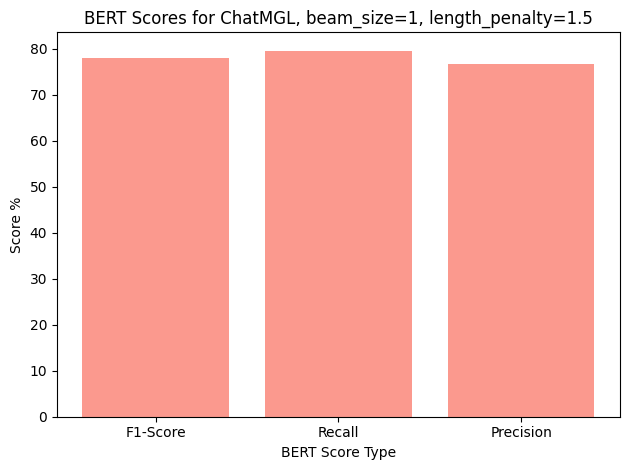

In [55]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

results = [bert_results["bert_f1"][0] * 100, bert_results["bert_recall"][0] * 100, bert_results["bert_precision"][0] * 100]

# Make a random dataset:
height = results
bars = ("F1-Score", "Recall", "Precision")
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color='salmon', alpha=0.8)

plt.xlabel("BERT Score Type")
plt.ylabel("Score %")
plt.title("BERT Scores for ChatMGL, beam_size=1, length_penalty=1.5")

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.tight_layout()
plt.show()
